# MNIST Dataset - Using TF Keras!

This notebooks is for the Kaggit Digit competition. That dataset is not quite the same as the normal MNIST dataset. See link:

https://www.kaggle.com/competitions/digit-recognizer

In [1]:
# The normal library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(f'TensorFlow version {tf.__version__}')
print(f'Numpy version {np.__version__}')

TensorFlow version 2.12.0
Numpy version 1.23.5


# Load Data and Organize

Load the image data, separate the images and the labels, and check for missing values.

In [2]:
# Load the CSV files
train = pd.read_csv('./image_data//mnist_train.csv')
test = pd.read_csv('./image_data/mnist_test.csv')

In [3]:
# Separate the training images and labels
train_y = train['label']
train_x = train.drop(labels= ['label'], axis=1)

# See the distribution of train_y
train_y.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [6]:
# Check for missing images in the train and test sets
# Training set
train_x.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
# Test set
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

The training labels are well distributed and there is no missing or corrupted data. Moving on!

# Data Processing

A few things need to happen. First, rescale the values between 0 and 1 and reshape the data to be in grayscale image form.
Then, turn th 0-9 digits categories into one-hot encoded versions.
Last, use Scikit-Lean to perform a train-test split across each category of the training set.

In [8]:
# Scikit-Learn train-test split function
from sklearn.model_selection import train_test_split

In [9]:
# Normalize the pixel values
train_x = train_x / 255.
test = test / 255.

In [10]:
# Reshape the data to be an image
train_x = train_x.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)
print(train_x.shape)

(42000, 28, 28, 1)


In [11]:
# One-hot encode the labels
train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)

In [12]:
# Check the shape
train_y.shape

(42000, 10)

In [13]:
# Make the train-test split in the training set
x_train, x_val, y_train, y_val = train_test_split(
    train_x,
    train_y,
    test_size=0.1,
    random_state=21
)

In [14]:
# Check the counts and values
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(37800, 28, 28, 1) (37800, 10)
(4200, 28, 28, 1) (4200, 10)


# Build the Model
I worked my way up in model complexity, but no need for you to see all the trash.
The built model will use convolutional neural networks, batch normalization, and dropout.

In [15]:
supermodel = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=(1, 1),
    padding='same',
    activation='relu'
    ),
    tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=(1, 1),
    padding='same',
    activation='relu'
    ),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=(1, 1),
    padding='same',
    activation='relu'
    ),
    tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=(1, 1),
    padding='same',
    activation='relu'
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(10, activation='softmax')
])

supermodel.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

supermodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1

To get more training data and to have a more robust system, we are going to use Image Augmentation.

In [16]:
# Import the Image Data Generator function, see to be depreciated
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# Create a Data Generator and fit to the training set
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False, # A hori-flip digit is not a number
    vertical_flip=False # A vert-flip digit is not a number
)

datagen.fit(x_train)

Another thing wer are going to do is use a callback to reduce the learning rate once we hit a training plateau.
That way, we can squeeze every ounce of knowledge out of training.

In [18]:
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    patience=7 # Because seven is greater than 5 and less than 10, for no reasion.
)

Also, set a larger batch size if you have the PC juice to do it.

In [19]:
batch_size = 2048

Fit the model using the Data Generator and the Callback. Go make yourself a coffee or three.

In [ ]:
# Fit the model to the data
history_supermodel = supermodel.fit(
        datagen.flow(
        train_x,
        train_y,
        batch_size=batch_size
    ),
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[lr_reduction],
    verbose=1
)

Did that take enough time? I hope so.
Let's plot the loss and accuracy and save the model.

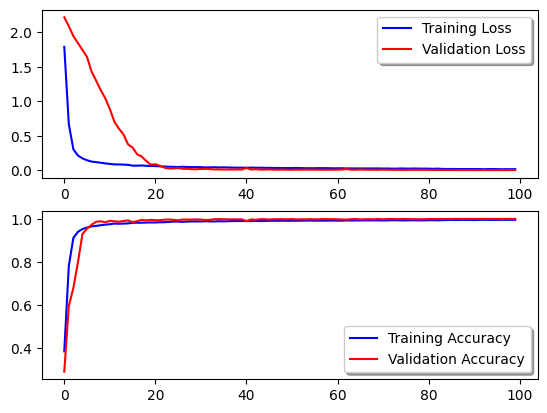

In [21]:
# Plot the training history, for knowledge.
fig, ax = plt.subplots(2, 1)

# First plot for loss
ax[0].plot(history_supermodel.history['loss'], color='b', label='Training Loss')
ax[0].plot(history_supermodel.history['val_loss'], color='r', label='Validation Loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# Second plot for accuracy
ax[1].plot(history_supermodel.history['accuracy'], color='b', label='Training Accuracy')
ax[1].plot(history_supermodel.history['val_accuracy'], color='r', label='Validation Accuracy', axes=ax[1])
legend = ax[1].legend(loc='best', shadow=True)

# Make Predictions

In [22]:
# Use the model to predict the raw results
results = supermodel.predict(test)
print(results)

875/875 [==============================] - 2s 2ms/step
[[5.1200253e-23 3.1254960e-19 1.0000000e+00 ... 2.0098950e-14
  9.5896507e-16 8.2225063e-25]
 [9.9999964e-01 1.9262369e-12 3.7964726e-10 ... 8.0581033e-13
  1.2163760e-09 2.5433087e-07]
 [3.4594553e-11 2.7455332e-10 3.1887645e-10 ... 3.2384524e-08
  6.7737730e-08 9.9993634e-01]
 ...
 [3.1855600e-27 3.8523082e-27 1.1124506e-19 ... 5.3899477e-23
  5.4854641e-17 5.0030283e-21]
 [8.1391074e-11 5.9968508e-10 1.5320643e-10 ... 1.4113765e-07
  5.7698575e-09 9.9997211e-01]
 [7.1981921e-25 9.2155013e-21 1.0000000e+00 ... 6.2945904e-16
  1.6041947e-15 3.5924622e-25]]


In [23]:
# Pick the highest probability result
results_comp = np.argmax(results, axis=1)
print(results_comp)

[2 0 9 ... 3 9 2]


In [24]:
# Turn the results into a pandas Series
results = pd.Series(results_comp, name="Label")
results.head()

0    2
1    0
2    9
3    0
4    3
Name: Label, dtype: int64

In [ ]:
# Generate the CSV
submission = pd.concat(
    [pd.Series(range(1, 28001), name="ImageID"), results],
    axis=1
)

submission.to_csv("cnn_mnist_jns.csv", index=False)